In [1]:
!pip install -qr requirements.txt

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

from ddim.models.unet import UNet
from ddim.models.model_utils import get_default_channel_mult, load_params
from ddim.diffusion.parameters import linear_beta_schedule, diff_params_from_betas
from ddim.diffusion.inference import denoising_loop
from ddim.training.steps import get_train_loop
from ddim.training.ema import EMA
from ddim.training.data import TimestepSampler, ImageDataset, DatasetSampler

import numpy as np
import random
import pickle

import jax
from jax import numpy as jnp
from jax.experimental.pjit import pjit, PartitionSpec
from jax.experimental.maps import mesh
import optax

import jmp
import time

import json
from tensorboardX import SummaryWriter

In [3]:
# Setup
config = {
    "seed": 1337,
    "mesh_shape": (1, 4, 2),
    "resume": None,
    "prefix": "with_decay",
    "training": {
        "learning_rate": 0.000001,
        "adam_b1": 0.9,
        "adam_b2": 0.999,
        "adam_decay": 0.0001,
        "batch_size": 1,
        "train_steps_total": 1000000000,
        "train_steps_per_iter": 2500,
        "eval_every": 10000,
        "save_every": 100000,
        "reduce_lr_steps": 100000,
        "reduce_lr_thresh": 0.01,
    },
    "data": {
        "data_glob": "data/portraits/*.jpg",
        "image_size": 128,
        "image_base_size": 512,
        "image_channels": 3,
    },
    "model": {
        "model_channels": 128,
        "num_head_channels": 64,
        "use_scale_shift_norm": True,
        "num_res_blocks": 2,
        "attention_resolutions": (32, 16, 8),
    },
    "diffusion": {
        "schedule_steps": 1000,
    }
}

In [4]:
# Basic jax mesh setup
prng = jax.random.PRNGKey(config["seed"])
devices = np.array(jax.devices()).reshape(config["mesh_shape"])
precision_policy = jmp.Policy(
    compute_dtype = jnp.bfloat16,
    param_dtype = jnp.bfloat16,
    output_dtype = jnp.float32,
)

In [5]:
# Set up model
prefix = config["prefix"]
model = UNet(
    dims = 2,
    model_channels = config["model"]["model_channels"],
    channel_mult = get_default_channel_mult(config["data"]["image_size"]),
    use_scale_shift_norm = config["model"]["use_scale_shift_norm"],
    dropout = 0.0, # TODO
    num_head_channels = config["model"]["num_head_channels"],
    num_res_blocks = config["model"]["num_res_blocks"],
    attention_resolutions = config["model"]["attention_resolutions"], # TODO seems to be some inconsistency here
    out_channels = config["data"]["image_channels"],
    dtype = precision_policy.compute_dtype,
    dtype_out = precision_policy.output_dtype
)

if config["resume"] is None:
    # Initialize parameters
    init_pjit = pjit(model.init, [None, PartitionSpec("batch", "x", "y"), PartitionSpec("batch")], PartitionSpec(None))
    with mesh(devices, ('batch', 'x', 'y')):
        params = init_pjit(prng, jnp.zeros((1, config["data"]["image_size"], config["data"]["image_size"], config["data"]["image_channels"])), jnp.zeros((1,)))
else:
    params = load_params(f"params_{prefix}_{resume}.pkl", devices)
    # TODO: Restore optimizer state?
    
params = precision_policy.cast_to_param(params)

"""    
param_count = 0
for param in jax.tree_util.tree_flatten(params)[0]:
    param_count += len(param.flatten())
print(f"param count: {param_count}")
"""

# Initialize diffusion
diff_params = diff_params_from_betas(linear_beta_schedule(config["diffusion"]["schedule_steps"]))

/home/lorenzd/.local/lib/python3.8/site-packages/jax/experimental/pjit.py:160: UserWarning: pjit is an experimental feature and probably has bugs!
  warn("pjit is an experimental feature and probably has bugs!")


In [6]:
# pjit the denoising loop
def denoising_loop_pjit(params, diff_params, images):
    return denoising_loop(model, params, diff_params, images)

denoising_loop_pjit = pjit(denoising_loop_pjit, 
   [
       PartitionSpec(None),
       PartitionSpec(None),
       PartitionSpec("batch", "x", "y")
   ], 
   PartitionSpec("batch", "x", "y"),
)

In [7]:
# Set up training
ema = EMA()
resize = None
if config["data"]["image_size"] != config["data"]["image_base_size"]:
    resize = config["data"]["image_size"]
dataset = ImageDataset(config["data"]["data_glob"], resize = resize)
data_sampler = DatasetSampler(dataset, batch_size = config["training"]["batch_size"])
timestep_sampler = TimestepSampler(config["diffusion"]["schedule_steps"], config["training"]["batch_size"])

opt = optax.chain(
    optax.adamw(
        b1=config["training"]["adam_b1"], 
        b2=config["training"]["adam_b2"], 
        learning_rate = config["training"]["learning_rate"], 
        eps=1e-8,
        weight_decay = config["training"]["adam_decay"]
    ),
    optax.inject_hyperparams(optax.scale)(1.0), # for LR halving
    optax.scale(-1.0)
)
opt_params = opt.init(params)

# Build a train loop that runs for 10000 batches
train_loop = get_train_loop(
    opt, 
    model, 
    diff_params, 
    data_sampler, 
    timestep_sampler, 
    ema, 
    how_many = config["training"]["train_steps_per_iter"],
)

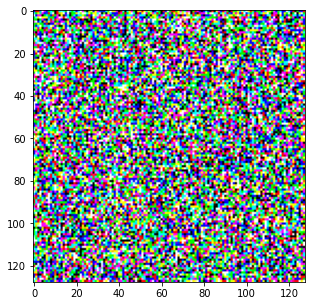

e: 2500, l: 18.817798614501953, img/s: 15.24
e: 5000, l: 23.413196563720703, img/s: 16.58
e: 7500, l: 23.73223304748535, img/s: 17.1


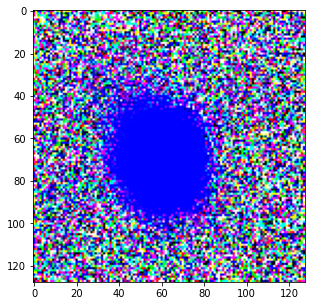

e: 10000, l: 23.854034423828125, img/s: 15.6


KeyboardInterrupt: 

In [ ]:
# Tensorboard instrumentation
writer = SummaryWriter()
writer.add_text("config", json.dumps(config, indent=4))

# Train
loss = None
reduce_lr_loss = []
start = time.time()
start_i = 0
if not config["resume"] is None:
    start_i = config["resume"] // config["training"]["train_steps_per_iter"]
    
with mesh(devices, ('batch', 'x', 'y')):
    for i in range(start_i, config["training"]["train_steps_total"] // config["training"]["train_steps_per_iter"]):
        step = i * config["training"]["train_steps_per_iter"]
        if step % config["training"]["eval_every"] == 0:
            # Progress shot
            prng_img = jax.random.PRNGKey(random.randint(0, 2**32))
            images_in = jax.random.normal(prng_img, (1, config["data"]["image_size"], config["data"]["image_size"], config["data"]["image_channels"]))
            timesteps_in = jnp.array([0,], dtype=jnp.int32)
            out = denoising_loop_pjit(params, diff_params, images_in.astype(jnp.float32))
            image = np.array(((out[0, :, :, :] + 1.0) * 127.5)).astype(np.uint8)
            plt.figure(figsize=(5, 5))
            plt.imshow(image)
            plt.show()
            
            # To tensorboard
            writer.add_image("out/image", image.T.transpose(0, 2, 1), i * config["training"]["train_steps_per_iter"])
        
        # Print loss
        img_s = (i - start_i) * round((config["training"]["train_steps_per_iter"] * config["training"]["batch_size"]) / (time.time() - start), 2)
        if not loss is None:
            print(f"e: {step}, l: {np.mean(loss)}, img/s: {img_s}")
        
            # learning rate halving
            reduce_lr_loss.extend(list(np.array(loss).flatten()))
            reduce_lr_loss = reduce_lr_loss[-config["training"]["reduce_lr_steps"]:]
            if step % config["training"]["reduce_lr_steps"] == 0:
                reduce_lr_loss_past = reduce_lr_loss[:config["training"]["reduce_lr_steps"]//2]
                reduce_lr_loss_now = reduce_lr_loss[config["training"]["reduce_lr_steps"]//2:]
                if reduce_lr_loss_now - reduce_lr_loss_past > config["training"]["reduce_lr_thresh"]:
                    opt_params[1].hyperparams["step_size"] = opt_params[1].hyperparams["step_size"] / 2
                writer.add_scalar("lr/step_diff", reduce_lr_loss_now - reduce_lr_loss_past, i * config["training"]["train_steps_per_iter"])
                
        # Tensorboard update
        if not loss is None:
            writer.add_scalar("images_sec", img_s, step)
            writer.add_scalar("loss/loop", np.mean(loss), step)
            writer.add_scalar("loss/lrstep", np.mean(reduce_lr_loss), step)
            writer.add_scalar("lr/scale", opt_params[1].hyperparams["step_size"], step)
            for idx, loss_v in enumerate(list(np.array(loss))):
                writer.add_scalar("loss/raw", loss_v, step + idx)
            
        # Save parameters
        if step % config["training"]["save_every"] == 0:
            with open(f"params_{prefix}_{step}.pkl", "wb") as f:
                pickle.dump(precision_policy.cast_to_output(params), f)
            
            with open(f"opt_params_{prefix}_{step}.pkl", "wb") as f:
                pickle.dump(precision_policy.cast_to_output(opt_params), f)
                
        # Run train_steps_per_iter training batches
        prng, params, opt_params, loss = train_loop(prng, params, opt_params)